In [1]:
import pandas as pd
from autogluon.tabular import TabularPredictor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from joblib import dump, load
from sklearn.ensemble import RandomForestRegressor
import json

C:\Users\Alice Dias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 📊RF
#### 💾 Carregamento e preparação da série temporal

In [25]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# Filtrar CP 4610 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Função para montar o design-matrix a partir de DateTime + colunas originais
def create_features(df):
    X = pd.DataFrame({
        "Hour": df["Hour"],
        "Temperature": df["Temperature"]
    })

    # mapeia TimeOfDay para ordinal
    tod_map = {"Manhã":0, "Tarde":1, "Noite":2}
    X["TimeOfDay"] = df["TimeOfDay"].map(tod_map).fillna(0).astype(int)

    # mapeia DayOfTheWeek para ordinal
    dofw_map = {"Segunda":0, "Terça":1, "Quarta":2, "Quinta":3, "Sexta":4, "Sábado":5, "Domingo":6}
    X["DayOfTheWeek"] = df["DayOfTheWeek"].map(dofw_map).fillna(0).astype(int)

    return X

#### ✂️ Split treino/teste

In [26]:
train_df = df_cp[df_cp["DateTime"] < "2023-09-30"]
test_df  = df_cp[
    (df_cp["DateTime"] >= "2023-09-30") &
    (df_cp["DateTime"] <  "2023-10-01")
]

X_train = create_features(train_df)
y_train = train_df["EnergyNormalized"].to_numpy()
X_test  = create_features(test_df)
y_test  = test_df["EnergyNormalized"].to_numpy()

In [27]:
# Escala features
# 1) Escolha as colunas a escalar
cols_to_scale = ["Hour", "Temperature"]

# 2) Crie o scaler e ajuste só no treino
scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])

# 3) Aplique a transformação somente nessas colunas
X_train_scaled = X_train.copy()
X_train_scaled[cols_to_scale] = scaler.transform(X_train[cols_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

#### 💾 Carregamento do modelo

In [28]:
# (Opcional) Carrega um modelo previamente treinado.
pipeline = load("predicts/RF/modelo/RF_pipeline.joblib")

#### 🛠️ Treinar

In [12]:
pipeline = Pipeline([
    ("scaler", ColumnTransformer([
        ("hour_temp", StandardScaler(), ["Hour", "Temperature"])
    ], remainder="passthrough")),  # as outras colunas passam sem alteração
    ("rf", RandomForestRegressor(n_estimators=100, random_state=123, n_jobs=-1))
])
pipeline.fit(X_train, y_train)

dump(pipeline, "predicts/RF/modelo/RF_pipeline.joblib") # Guarda o modelo treinado.

['predicts/RF/modelo/RF_pipeline.joblib']

#### 📈 Previsão e avaliação

In [31]:
y_pred = pipeline.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = (np.abs((y_test - y_pred) / y_test)*100).mean()
r2 = r2_score(y_test, y_pred)

# exportar metricas
metrics = {
    "MAE":   mae,
    "MSE":   mse,
    "RMSE":  rmse,
    "MAPE":  mape,
    "R²": r2
}

with open("./predicts/RF/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.5f}")

MAE:  0.00337
MSE:  0.00002
RMSE: 0.00438
MAPE: 7.55%
R²: 0.68452


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                                      |
|----------------------------------------------|---------|----------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00337 | O erro médio absoluto é bastante reduzido, indicando que, em média, a RF prevê o consumo com um desvio muito pequeno em relação aos valores reais. |
| **MSE** (Erro Quadrático Médio)              | 0.00002 | Um erro quadrático médio extremamente baixo, sugerindo que grandes erros são raros. O modelo apresenta alta precisão e estabilidade nas previsões. |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00438 | Com um RMSE inferior a 0.005, o modelo consegue manter os erros dentro de uma margem pequena em relação à variabilidade do consumo energético. |
| **MAPE** (Erro Percentual Absoluto Médio)    | 7.55%   | O erro percentual médio de cerca de 7,5\% mostra que a RF prevê com boa precisão, tendo melhor desempenho do que o ARIMA. |
| **R²**   | 0.68452  | O modelo explica cerca de 68% da variabilidade dos dados reais — desempenho sólido |

#### 🖼️ Visualização gráfica

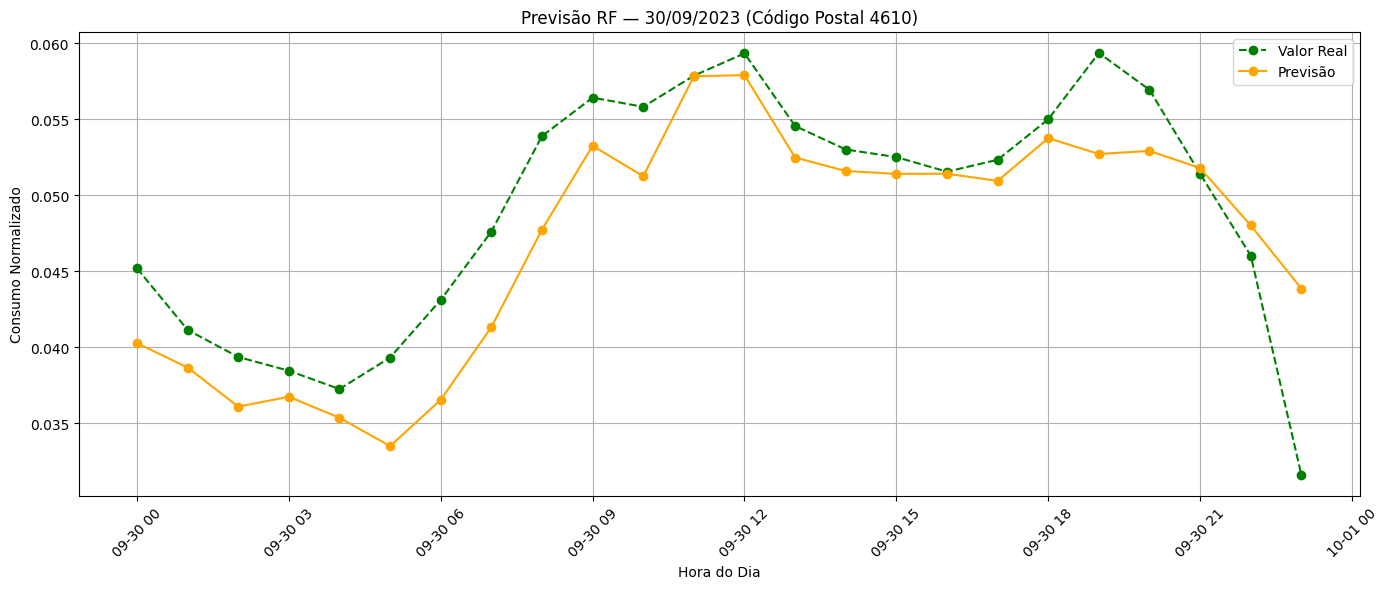

In [7]:
timestamps = test_df["DateTime"]

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_test, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão RF — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/RF/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📊LSTM
#### 💾 Carregamento e preparação da série temporal

In [32]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# Filtrar CP 4610 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Crie um DataFrame de features estáticas único por série:
static_feats = (
    df_cp[["ZipCode", "PopulationDensity"]]
    .drop_duplicates()   # agora tem apenas 1 linha: ZipCode 4610
    .copy()
)

# Extrai as features estáticas da série (como densidade populacional).
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

# Constrói o TimeSeriesDataFrame com colunas de tempo, id e features estáticas.
known_covs = ["Hour","TimeOfDay", "Temperature", "DayOfTheWeek"]

#### ✂️ Split treino/teste

In [33]:
# Divide os dados em treino e teste, reservando as últimas 24h como hold-out.
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo LSTM


In [34]:
# (Opcional) Carrega um modelo previamente treinado.
predictor_lstm = TimeSeriesPredictor.load("./predicts/LSTM/modelo/")

In [23]:
# --- 3) Treinar um LSTM (via RNNModel) ---
predictor_lstm = TimeSeriesPredictor(
    target="EnergyNormalized",
    prediction_length=24,
    freq="h",
    known_covariates_names=known_covs,
    path="predicts/LSTM/modelo"
).fit(
    train_data,
    tuning_data=test_data,
    hyperparameters={
        "DeepAR": {
            "context_length": 48,    # quantas horas passadas a rede olha
            "hidden_size":   64,    # tamanho do estado escondido
            "num_layers":    2,     # número de camadas LSTM
            "dropout":       0.1,
            "learning_rate": 1e-3,
            "epochs":        20,
            "target_scaler": "standard",
        }
    },
    presets="medium_quality",
    time_limit=3600,               # 1h de tempo máximo
)

predictor_lstm.save() # Guarda o modelo treinado.

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\LSTM\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       0.74 GB / 7.88 GB (9.4%)
Disk Space Avail:   886.20 GB / 931.51 GB (95.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DeepAR': {'context_length': 48,
                                'dropout': 0.1,
                                'epochs': 20,
                                'hidden_size': 64,
                                'learning_rate': 0.001,
                                'num_layers': 2,
                                'target_scaler': 'standard'}},
 'known_covariates_names

#### 🔮Preparação das covariáveis futuras para previsão

In [35]:
# 1.1) Pega último timestamp de train_data
last_time = train_data.index.get_level_values("timestamp").max()

# 1.2) Cria as 24 horas seguintes
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),
    periods=24,
    freq="h"
)

future_df = df_cp.loc[
    df_cp["DateTime"].isin(future_times),
    ["ZipCode", "DateTime"] + known_covs
].copy()

# 1.4) Converte para TimeSeriesDataFrame
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="ZipCode",
    timestamp_column="DateTime"
)[known_covs]

#### 📈 Previsão e avaliação

In [36]:
preds = predictor_lstm.predict(
    data=train_data,
    known_covariates=future_known_covs
)

# Extrai a previsão pontual (mediana) e os valores reais correspondentes.
y_pred = preds["0.5"]
y_true = test_data["EnergyNormalized"].loc[preds.index]
metrics = predictor_lstm.evaluate(test_data)

#### 📊 Cálculo de métricas

In [37]:
# Se quiser um array simples:
y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

n = len(y_true)
assert n == len(y_pred), "y_true e y_pred devem ter mesmo tamanho"

# Erros
abs_errs    = np.abs(y_true - y_pred)
sq_errs     = (y_true - y_pred) ** 2
pct_errs    = np.abs((y_true - y_pred) / y_true) * 100  # em %

# Métricas
MAE  = abs_errs.mean()
MSE  = sq_errs.mean()
RMSE = np.sqrt(MSE)
MAPE = pct_errs.mean()
r2 = r2_score(y_true, y_pred)

# exportar metricas
metrics = {
    "MAE":   mae,
    "MSE":   mse,
    "RMSE":  rmse,
    "MAPE":  mape,
    "R²": r2
}

with open("./predicts/LSTM/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f'MAE: {MAE:.5f}')
print(f'MSE: {MSE:.5f}')
print(f'RMSE: {RMSE:.5f}')
print(f'MAPE: {MAPE:.5f}%')
print(f"R²: {r2:.5f}")

MAE: 0.00239
MSE: 0.00001
RMSE: 0.00336
MAPE: 5.21063%
R²: 0.81448


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                                |
|----------------------------------------------|---------|----------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00239 | O LSTM apresenta um erro médio extremamente baixo, o que indica uma capacidade muito elevada de seguir o consumo real hora a hora.           |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O valor reduzido mostra que o modelo raramente comete grandes erros e tem previsões muito estáveis, sem picos de desvio elevados.            |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00336 | Representa um erro médio em torno de 0.0031, muito inferior ao observado na maioria dos modelos testados, sinalizando alta precisão global.  |
| **MAPE** (Erro Percentual Absoluto Médio)    | 5.21%   | O LSTM atinge o melhor resultado percentual até agora, errando em média 5.21\% em relação aos valores reais — excelente para aplicações reais. |
| **R²**   | 0.81448  | O modelo explica 81% da variabilidade dos dados reais — ótimo!                                                                               |

#### 🖼️ Visualização gráfica

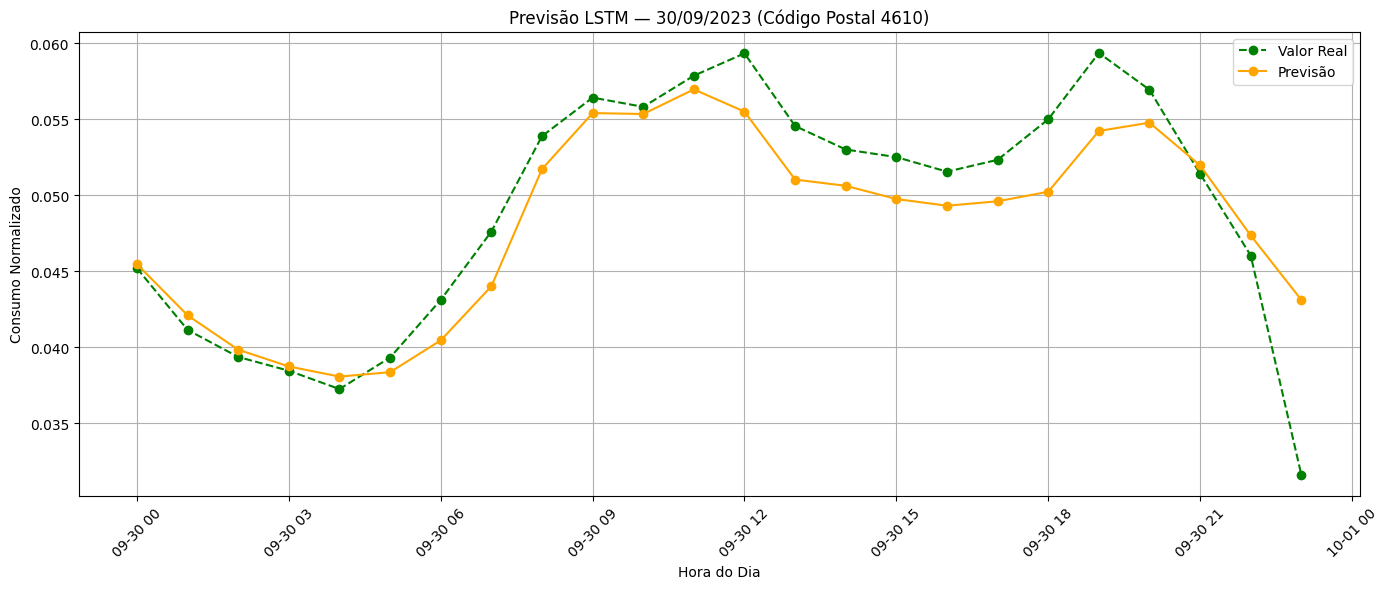

In [14]:
# Extrair os timestamps do índice
timestamps = preds.index.get_level_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão LSTM — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/LSTM/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📊CNN
#### 💾 Carregamento e preparação da série temporal

In [38]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# Filtrar CP 4610 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Crie um DataFrame de features estáticas único por série:
static_feats = (
    df_cp[["ZipCode", "PopulationDensity"]]
    .drop_duplicates()   # agora tem apenas 1 linha: ZipCode 4610
)

# Extrai as features estáticas da série (como densidade populacional).
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

# Constrói o TimeSeriesDataFrame com colunas de tempo, id e features estáticas.
known_covs = ["Hour","TimeOfDay", "Temperature", "DayOfTheWeek"]

#### ✂️ Split treino/teste

In [39]:
# Divide os dados em treino e teste, reservando as últimas 24h como hold-out.
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo CNN

In [40]:
# (Opcional) Carrega um modelo previamente treinado.
predictor_cnn = TimeSeriesPredictor.load("./predicts/CNN/modelo/")

In [35]:
# --- 3) Treinar um CNN ---
predictor_cnn = TimeSeriesPredictor(
    target="EnergyNormalized",
    prediction_length=24,
    freq="h",
    known_covariates_names=known_covs,
    path="predicts/CNN/modelo"
).fit(
    train_data,
    tuning_data=test_data,
    hyperparameters={
        "WaveNet": {}
    },
    presets="medium_quality",
    time_limit=600,
    skip_model_selection=True
)

predictor_cnn.save() # Guarda o modelo treinado.

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\CNN\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       1.11 GB / 7.88 GB (14.1%)
Disk Space Avail:   886.19 GB / 931.51 GB (95.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'WaveNet': {}},
 'known_covariates_names': ['Hour', 'TimeOfDay', 'Temperature', 'DayOfTheWeek'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'EnergyNormalized',
 'time_limit': 600,
 've

#### 🔮Preparação das covariáveis futuras para previsão

In [41]:
# 1.1) Pega último timestamp de train_data
last_time = train_data.index.get_level_values("timestamp").max()

# 1.2) Cria as 24 horas seguintes
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),
    periods=24,
    freq="h"
)

future_df = df_cp.loc[
    df_cp["DateTime"].isin(future_times),
    ["ZipCode", "DateTime"] + known_covs
].copy()

# 1.4) Converte para TimeSeriesDataFrame
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="ZipCode",
    timestamp_column="DateTime"
)[known_covs]

#### 📈 Previsão e avaliação

In [42]:
preds = predictor_cnn.predict(
    data=train_data,
    known_covariates=future_known_covs
)

# Extrai a previsão pontual (mediana) e os valores reais correspondentes.
y_pred = preds["0.5"]
y_true = test_data["EnergyNormalized"].loc[preds.index]
metrics = predictor_cnn.evaluate(test_data)

#### 📊 Cálculo de métricas

In [43]:
# Se quiser um array simples:
y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

n = len(y_true)
assert n == len(y_pred), "y_true e y_pred devem ter mesmo tamanho"

# Erros
abs_errs    = np.abs(y_true - y_pred)
sq_errs     = (y_true - y_pred) ** 2
pct_errs    = np.abs((y_true - y_pred) / y_true) * 100  # em %

# Métricas
MAE  = abs_errs.mean()
MSE  = sq_errs.mean()
RMSE = np.sqrt(MSE)
MAPE = pct_errs.mean()
r2 = r2_score(y_true, y_pred)

# exportar metricas
metrics = {
    "MAE":   mae,
    "MSE":   mse,
    "RMSE":  rmse,
    "MAPE":  mape,
    "R²": r2
}

with open("./predicts/CNN/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f'MAE: {MAE:.5f}')
print(f'MSE: {MSE:.5f}')
print(f'RMSE: {RMSE:.5f}')
print(f'MAPE: {MAPE:.5f}%')
print(f"R²: {r2:.5f}")

MAE: 0.00373
MSE: 0.00003
RMSE: 0.00516
MAPE: 8.07783%
R²: 0.56154


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                                                    |
|----------------------------------------------|---------|------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00373 | O erro médio absoluto é baixo, indicando que as previsões da CNN estão geralmente muito próximas dos valores reais de consumo energético.                        |
| **MSE** (Erro Quadrático Médio)              | 0.00003 | O erro quadrático médio também é reduzido, o que mostra que grandes desvios entre previsão e realidade são pouco frequentes.                                     |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00516 | Com um RMSE inferior a 0.01, o modelo mantém os erros dentro de uma margem aceitável, demonstrando uma boa estabilidade nas previsões horárias.                  |
| **MAPE** (Erro Percentual Absoluto Médio)    | 8.08%   | O modelo apresenta um erro percentual médio de aproximadamente 8\%, o que é considerado bom para séries temporais energéticas, mas ligeiramente inferior ao LSTM. |
| **R²**   | 0.56154  | O modelo explica cerca de 56% da variabilidade dos dados reais                                                                                                   |

#### 🖼️ Visualização gráfica

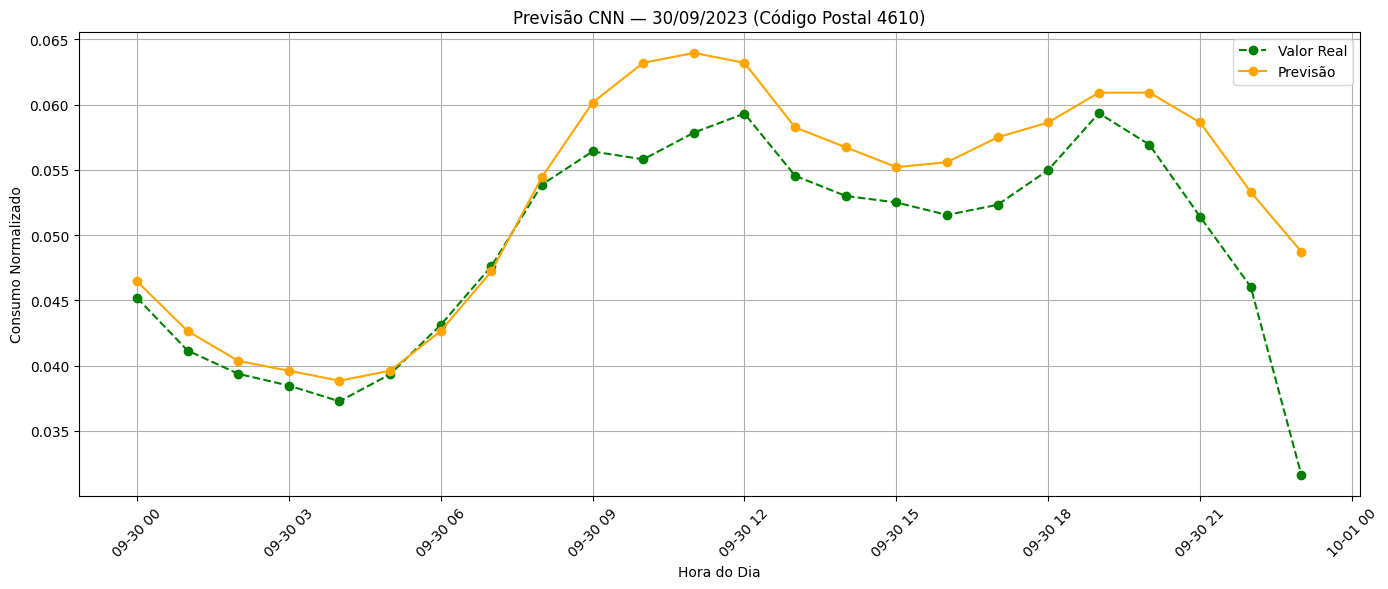

In [21]:
# Extrair os timestamps do índice
timestamps = preds.index.get_level_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão CNN — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/CNN/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📊XGBoost
#### 💾 Carregamento e preparação da série temporal

In [44]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# Filtrar CP 4610 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Crie um DataFrame de features estáticas único por série:
static_feats = (
    df_cp[["ZipCode", "PopulationDensity"]]
    .drop_duplicates()   # agora tem apenas 1 linha: ZipCode 4610
)

# Extrai as features estáticas da série (como densidade populacional).
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

# Constrói o TimeSeriesDataFrame com colunas de tempo, id e features estáticas.
known_covs = ["Hour","TimeOfDay", "Temperature", "DayOfTheWeek"]

#### ✂️ Split treino/teste

In [45]:
# Divide os dados em treino e teste, reservando as últimas 24h como hold-out.
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo XGBoost

In [ ]:
# (Opcional) Carrega um modelo previamente treinado.
predictor_xgboost = TimeSeriesPredictor.load("./predicts/XGBoost/modelo/")

In [47]:
# --- 3) Treinar ---
predictor_xgboost = TimeSeriesPredictor(
    target="EnergyNormalized",
    prediction_length=24,
    freq="h",
    known_covariates_names=known_covs,
    path="predicts/XGBoost/modelo"
).fit(
    train_data,
    tuning_data=test_data,
    hyperparameters={
         # DirectTabular é o wrapper que permite usar TabularPredictor
        "DirectTabular": {
            # aqui especificamos que só queremos o sub-modelo XGBoost
            "models": ["XGB"]
        }
    },
    presets="medium_quality",
    time_limit=600,
    skip_model_selection=True
)

predictor_xgboost.save() # Guarda o modelo treinado.

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\XGBoost\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       1.14 GB / 7.88 GB (14.5%)
Disk Space Avail:   886.17 GB / 931.51 GB (95.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DirectTabular': {'models': ['XGB']}},
 'known_covariates_names': ['Hour', 'TimeOfDay', 'Temperature', 'DayOfTheWeek'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'EnergyNormalized

#### 🔮Preparação das covariáveis futuras para previsão

In [48]:
# 1.1) Pega último timestamp de train_data
last_time = train_data.index.get_level_values("timestamp").max()

# 1.2) Cria as 24 horas seguintes
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),
    periods=24,
    freq="h"
)

future_df = df_cp.loc[
    df_cp["DateTime"].isin(future_times),
    ["ZipCode", "DateTime"] + known_covs
].copy()

# 1.4) Converte para TimeSeriesDataFrame
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="ZipCode",
    timestamp_column="DateTime"
)[known_covs]

#### 📈 Previsão e avaliação

In [49]:
preds = predictor_xgboost.predict(
    data=train_data,
    known_covariates=future_known_covs
)

# Extrai a previsão pontual (mediana) e os valores reais correspondentes.
y_pred = preds["0.5"]
y_true = test_data["EnergyNormalized"].loc[preds.index]
metrics = predictor_xgboost.evaluate(test_data)

Model not specified in predict, will default to the model with the best validation score: DirectTabular
Model not specified in predict, will default to the model with the best validation score: DirectTabular


#### 📊 Cálculo de métricas

In [50]:
# Se quiser um array simples:
y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

n = len(y_true)
assert n == len(y_pred), "y_true e y_pred devem ter mesmo tamanho"

# Erros
abs_errs    = np.abs(y_true - y_pred)
sq_errs     = (y_true - y_pred) ** 2
pct_errs    = np.abs((y_true - y_pred) / y_true) * 100  # em %

# Métricas
MAE  = abs_errs.mean()
MSE  = sq_errs.mean()
RMSE = np.sqrt(MSE)
MAPE = pct_errs.mean()
r2 = r2_score(y_true, y_pred)

# exportar metricas
metrics = {
    "MAE":   mae,
    "MSE":   mse,
    "RMSE":  rmse,
    "MAPE":  mape,
    "R²": r2
}

with open("./predicts/XGBoost/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f'MAE: {MAE:.5f}')
print(f'MSE: {MSE:.5f}')
print(f'RMSE: {RMSE:.5f}')
print(f'MAPE: {MAPE:.5f}%')
print(f"R²: {r2:.5f}")

MAE: 0.00280
MSE: 0.00001
RMSE: 0.00345
MAPE: 5.91124%
R²: 0.80444


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                                                                                         |
|----------------------------------------------|---------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00280 | O modelo comete, em média, um erro de 0.0028 unidades normalizadas por hora. É um valor muito baixo, indicando alta precisão nas previsões.                                                           |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O erro médio ao quadrado também é muito pequeno. Esta métrica penaliza mais fortemente erros grandes, o que indica que o modelo não cometeu grandes desvios.                                          |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00345 | A raiz do erro quadrático médio. Tem as mesmas unidades do target (consumo normalizado), facilitando a interpretação. Um valor próximo de zero é desejável — e este está ótimo.                       |
| **MAPE** (Erro Percentual Absoluto Médio)    | 5.91%   | O modelo erra em média 5.91% do valor real — um valor muito bom, mas mesmo assim o LSTM teve melhor resultado.                                                                                         |
| **R²**   | 0.80444 | O modelo explica aproximadamente 80,4% da variabilidade dos dados reais. Isso significa que ele consegue representar bem a estrutura da série temporal, captando padrões e flutuações com eficiência. |

#### 🖼️ Visualização gráfica

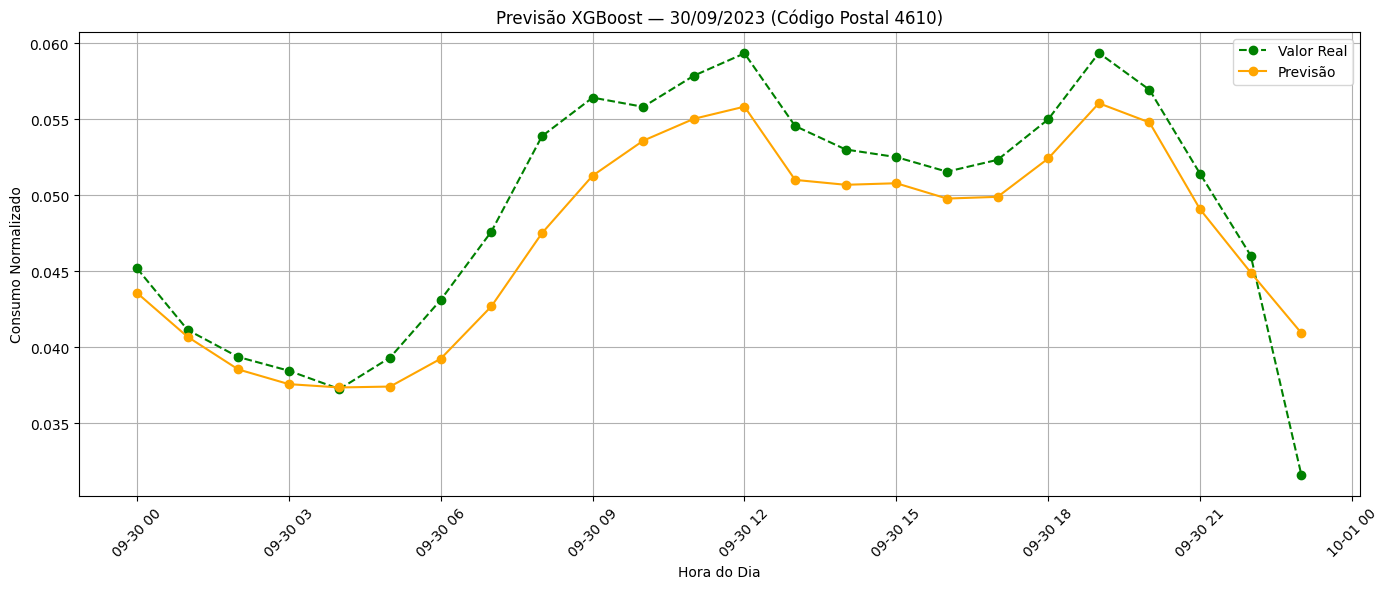

In [51]:
# Extrair os timestamps do índice
timestamps = preds.index.get_level_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão XGBoost — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/XGBoost/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📊Extra Trees
#### 💾 Carregamento e preparação da série temporal

In [9]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# Filtrar CP 4610 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Crie um DataFrame de features estáticas único por série:
static_feats = (
    df_cp[["ZipCode", "PopulationDensity"]]
    .drop_duplicates()   # agora tem apenas 1 linha: ZipCode 4610
)

# Extrai as features estáticas da série (como densidade populacional).
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

# Constrói o TimeSeriesDataFrame com colunas de tempo, id e features estáticas.
known_covs = ["Hour","TimeOfDay", "Temperature", "DayOfTheWeek"]

#### ✂️ Split treino/teste

In [10]:
# Divide os dados em treino e teste, reservando as últimas 24h como hold-out.
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo Extra Trees

In [11]:
# (Opcional) Carrega um modelo previamente treinado.
predictor_xt = TimeSeriesPredictor.load("./predicts/xt/modelo/")

Loading predictor from path D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\xt\modelo


In [4]:
predictor_xt = TimeSeriesPredictor(
    target="EnergyNormalized",
    prediction_length=24,
    freq="h",
    known_covariates_names=known_covs,
    path="predicts/xt/modelo"
).fit(
    train_data,
    tuning_data=test_data,
    hyperparameters={
         "DirectTabular": {
            "models": ["XT"],      # só ExtraTrees
            "XT": {}               # parâmetros default
        }
    },
    presets="medium_quality",
    time_limit=600,
    skip_model_selection=True
)

predictor_xt.save() # Guarda o modelo treinado.

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\xt\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       1.00 GB / 7.88 GB (12.6%)
Disk Space Avail:   886.09 GB / 931.51 GB (95.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DirectTabular': {'XT': {}, 'models': ['XT']}},
 'known_covariates_names': ['Hour', 'TimeOfDay', 'Temperature', 'DayOfTheWeek'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'EnergyNormal

#### 🔮Preparação das covariáveis futuras para previsão

In [12]:
# 1.1) Pega último timestamp de train_data
last_time = train_data.index.get_level_values("timestamp").max()

# 1.2) Cria as 24 horas seguintes
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),
    periods=24,
    freq="h"
)

future_df = df_cp.loc[
    df_cp["DateTime"].isin(future_times),
    ["ZipCode", "DateTime"] + known_covs
].copy()

# 1.4) Converte para TimeSeriesDataFrame
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    future_df,
    id_column="ZipCode",
    timestamp_column="DateTime"
)[known_covs]

#### 📈 Previsão e avaliação

In [13]:
preds = predictor_xt.predict(
    data=train_data,
    known_covariates=future_known_covs
)

# Extrai a previsão pontual (mediana) e os valores reais correspondentes.
y_pred = preds["0.5"]
y_true = test_data["EnergyNormalized"].loc[preds.index]
metrics = predictor_xt.evaluate(test_data)

Model not specified in predict, will default to the model with the best validation score: DirectTabular
Model not specified in predict, will default to the model with the best validation score: DirectTabular


#### 📊 Cálculo de métricas

In [14]:
# Se quiser um array simples:
y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

n = len(y_true)
assert n == len(y_pred), "y_true e y_pred devem ter mesmo tamanho"

# Erros
abs_errs    = np.abs(y_true - y_pred)
sq_errs     = (y_true - y_pred) ** 2
pct_errs    = np.abs((y_true - y_pred) / y_true) * 100  # em %

# Métricas
MAE  = abs_errs.mean()
MSE  = sq_errs.mean()
RMSE = np.sqrt(MSE)
MAPE = pct_errs.mean()
r2 = r2_score(y_true, y_pred)

# exportar metricas
metrics = {
    "MAE":   MAE,
    "MSE":   MSE,
    "RMSE":  RMSE,
    "MAPE":  MAPE,
    "R²": r2
}

with open("./predicts/xt/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f'MAE: {MAE:.5f}')
print(f'MSE: {MSE:.5f}')
print(f'RMSE: {RMSE:.5f}')
print(f'MAPE: {MAPE:.5f}%')
print(f"R²: {r2:.5f}")

MAE: 0.00281
MSE: 0.00001
RMSE: 0.00344
MAPE: 5.91836%
R²: 0.80446


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                        |
|----------------------------------------------|---------|--------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00281 | 	Em média, o modelo erra apenas 0.00281 unidades normalizadas por hora — um valor muito baixo, indicando alta precisão.              |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O erro médio ao quadrado é extremamente pequeno, o que indica que não houve grandes desvios nas previsões.                           |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00344 | O desvio médio das previsões em relação aos valores reais é de apenas 0.00344, confirmando previsões próximas da realidade.          |
| **MAPE** (Erro Percentual Absoluto Médio)    | 5.92%   | O modelo errou em média apenas 5.92% dos valores reais — excelente resultado para previsão de séries temporais energéticas.          |
| **R²**   | 0.80446 | O modelo conseguiu explicar aproximadamente 80.4% da variabilidade dos dados reais. Isto demonstra uma forte capacidade explicativa. |

#### 🖼️ Visualização gráfica

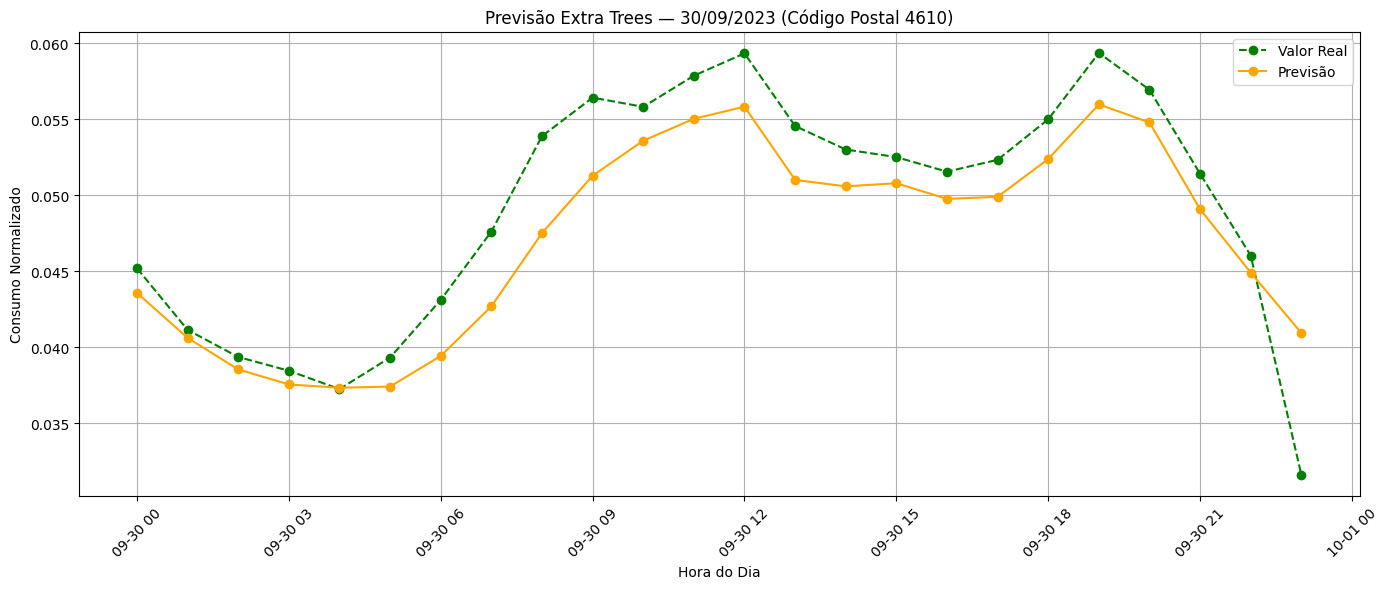

In [15]:
# Extrair os timestamps do índice
timestamps = preds.index.get_level_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão Extra Trees — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/xt/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📊NARX
#### 💾 Carregamento e preparação da série temporal

In [34]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# Filtrar CP 4610 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# --- Cria features de lag do target (NARX) ---
# lag de 1 hora e de 24 horas
df_cp["lag_1"]  = df_cp["EnergyNormalized"].shift(1)
df_cp["lag_24"] = df_cp["EnergyNormalized"].shift(24)

# descarta as primeiras 24 linhas que ficaram com NaN nos lags
df_cp = df_cp.dropna(subset=["lag_1", "lag_24"]).copy()

# --- Static features (coleção única por série) ---
static_feats = (
    df_cp[["ZipCode", "PopulationDensity"]]
    .drop_duplicates()
)

# --- Constrói o TimeSeriesDataFrame ---
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

# --- Define covariáveis conhecidas (incluindo lags) ---
known_covs = ["Hour", "TimeOfDay", "Temperature", "DayOfTheWeek", "lag_1", "lag_24"]

#### ✂️ Split treino/teste

In [35]:
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo

In [ ]:
predictor_narx = TimeSeriesPredictor.load("./predicts/NARX/modelo/")

In [36]:
predictor_narx = TimeSeriesPredictor(
    target="EnergyNormalized",
    freq="h",
    prediction_length=24,
    known_covariates_names=known_covs,
    path="predicts/NARX/modelo"
).fit(
    train_data=train_data,
    tuning_data=test_data,
    hyperparameters={"DirectTabular": {}},
    time_limit=300,
    presets="medium_quality",
    skip_model_selection=True,  # pula ensembles avançados
)

predictor_narx.save() # Guarda o modelo treinado.

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\NARX\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       6.29 GB / 15.93 GB (39.5%)
Disk Space Avail:   698.56 GB / 931.46 GB (75.0%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DirectTabular': {}},
 'known_covariates_names': ['Hour',
                            'TimeOfDay',
                            'Temperature',
                            'DayOfTheWeek',
                            'lag_1',
                            'lag_24'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.

#### 📈 Previsão e avaliação

In [65]:
#    Use train_data para previsão à frente de 24h
preds = predictor_narx.predict(
    train_data,
    known_covariates=test_data
)

y_pred = preds["0.5"].droplevel(0)
y_true = (
    test_data["EnergyNormalized"]
    .droplevel(0)              # do TSDF para Series
    .loc[y_pred.index]         # só nas 24 horas previstas
)

Model not specified in predict, will default to the model with the best validation score: DirectTabular


#### 📊 Cálculo de métricas

In [66]:
MAE  = mean_absolute_error(y_true, y_pred)
MSE  = mean_squared_error(y_true, y_pred)
RMSE = np.sqrt(MSE)
MAPE = (np.abs((y_true - y_pred) / y_true) * 100).mean()
r2 = r2_score(y_true, y_pred)

# exportar metricas
metrics = {
    "MAE":   MAE,
    "MSE":   MSE,
    "RMSE":  RMSE,
    "MAPE":  MAPE,
    "R²": r2
}

with open("./predicts/NARX/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f'MAE: {MAE:.5f}')
print(f'MSE: {MSE:.5f}')
print(f'RMSE: {RMSE:.5f}')
print(f'MAPE: {MAPE:.5f}%')
print(f"R²: {r2:.5f}")

MAE: 0.00157
MSE: 0.00001
RMSE: 0.00253
MAPE: 3.64473%
R²: 0.89428


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                  |
|----------------------------------------------|---------|--------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00157 | 	O erro absoluto médio foi muito baixo, indicando que, em média, a diferença entre os valores previstos e os reais foi pequena. |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O erro quadrático foi baixo, mostrando que o modelo raramente cometeu erros grandes.                                           |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00253 | A sua raiz também foi baixa, mostrando que o modelo raramente cometeu erros grandes.                                           |
| **MAPE** (Erro Percentual Absoluto Médio)    | 3.64%   | O erro percentual médio absoluto foi inferior a 5%, o que é considerado ótimo em tarefas de previsão.                          |
| **R²**   | 0.89428 | O coeficiente de determinação está muito próximo de 1, o que indica que o modelo conseguiu explicar aproximadamente 89% da variabilidade dos dados reais — sinal de um ajuste muito bom. |

#### 🖼️ Visualização gráfica

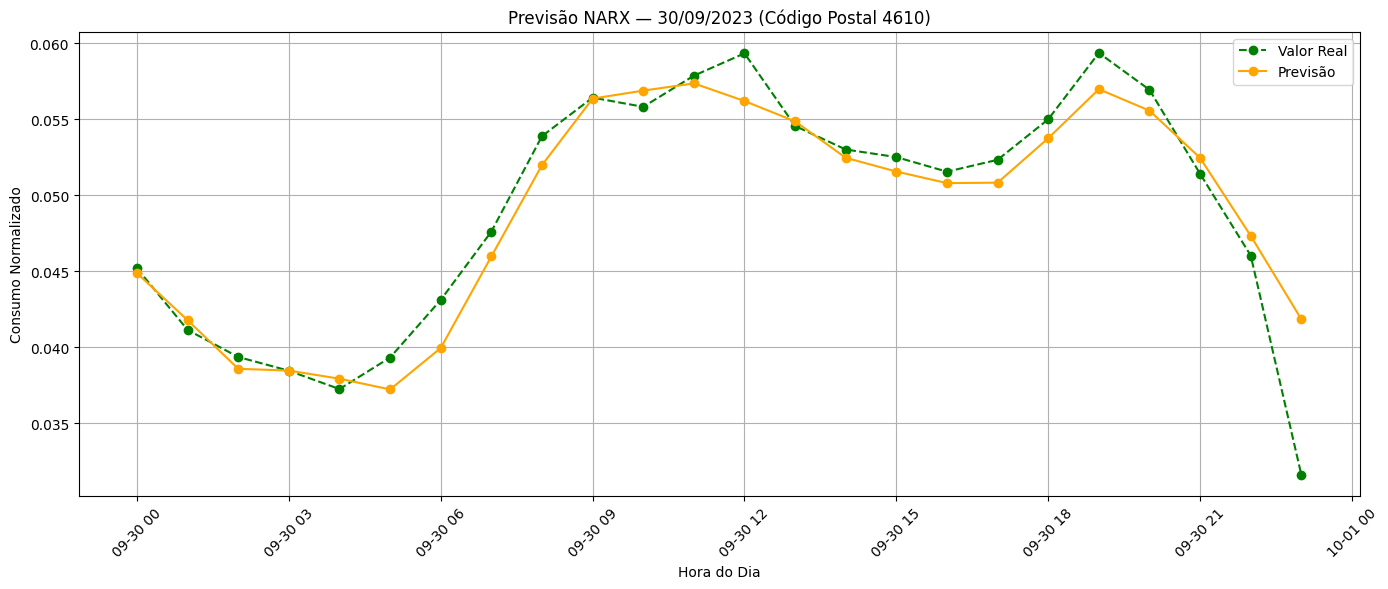

In [67]:
# Extrair os timestamps do índice
timestamps = preds.index.get_level_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão NARX — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/NARX/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📊AutoML
#### 💾 Carregamento e preparação da série temporal

In [2]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# Filtrar CP 4610 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# --- Static features (coleção única por série) ---
static_feats = (
    df_cp[["ZipCode", "PopulationDensity"]]
    .drop_duplicates()
)

# --- Constrói o TimeSeriesDataFrame ---
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

# --- Define covariáveis conhecidas (incluindo lags) ---
known_covs = ["Hour", "TimeOfDay", "Temperature", "DayOfTheWeek"]

#### ✂️ Split treino/teste

In [3]:
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo

In [4]:
predictor_AutoML = TimeSeriesPredictor.load("./predicts/AutoML/modelo/")

In [12]:
# Treina o AutoML (vai testar vários modelos e eleger o melhor)
predictor_AutoML = TimeSeriesPredictor(
    target="EnergyNormalized",
    freq="h",
    prediction_length=24,
    known_covariates_names=known_covs,
    path="predicts/AutoML/modelo"
).fit(
    train_data=train_data,
    tuning_data=test_data,
    presets="best",       # 'best' para máxima acurácia; 'medium_quality' para protótipo rápido
    time_limit=3200       # tempo limite em segundos
)

predictor_AutoML.save() # Guarda o modelo treinado.

Beginning AutoGluon training... Time limit = 7200s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\AutoML\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       4.29 GB / 15.93 GB (26.9%)
Disk Space Avail:   698.02 GB / 931.46 GB (74.9%)
Setting presets to: best

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': 'default',
 'known_covariates_names': ['Hour', 'TimeOfDay', 'Temperature', 'DayOfTheWeek'],
 'num_val_windows': 2,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'EnergyNormalized',
 'time_limit': 7200,
 'verbosity':

#### 📈 Previsão e avaliação

In [5]:
#    Use train_data para previsão à frente de 24h
preds = predictor_AutoML.predict(
    train_data,
    known_covariates=test_data
)

y_pred = preds["0.5"].droplevel(0)
y_true = (
    test_data["EnergyNormalized"]
    .droplevel(0)              # do TSDF para Series
    .loc[y_pred.index]         # só nas 24 horas previstas
)

#### 📊 Cálculo de métricas

In [6]:
MAE  = mean_absolute_error(y_true, y_pred)
MSE  = mean_squared_error(y_true, y_pred)
RMSE = np.sqrt(MSE)
MAPE = (np.abs((y_true - y_pred) / y_true) * 100).mean()
R2   = r2_score(y_true, y_pred)

# Exporta métricas para JSON
metrics = {
    "MAE":   MAE,
    "MSE":   MSE,
    "RMSE":  RMSE,
    "MAPE":  MAPE,
    "R²":    R2
}
with open("./predicts/AutoML/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print(f"MAE:  {MAE:.5f}")
print(f"MSE:  {MSE:.5f}")
print(f"RMSE: {RMSE:.5f}")
print(f"MAPE: {MAPE:.2f}%")
print(f"R²:   {R2:.5f}")

MAE:  0.00131
MSE:  0.00001
RMSE: 0.00249
MAPE: 3.12%
R²:   0.89748


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                    |
|----------------------------------------------|---------|--------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00131 | 	Indica pequenas diferenças entre os valores previstos e reais.                                  |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | Também muito baixo, refletindo previsões com baixos desvios.                                     |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00249 | Também muito baixo, refletindo previsões com baixos desvios.                                     |
| **MAPE** (Erro Percentual Absoluto Médio)    | 3.12%   | O erro percentual médio é bastante reduzido, o que é excelente em contextos de séries temporais. |
| **R²**   | 0.89748 | Indica que quase 90% da variabilidade do consumo foi explicada pelo modelo.                      |

#### 🖼️ Visualização gráfica

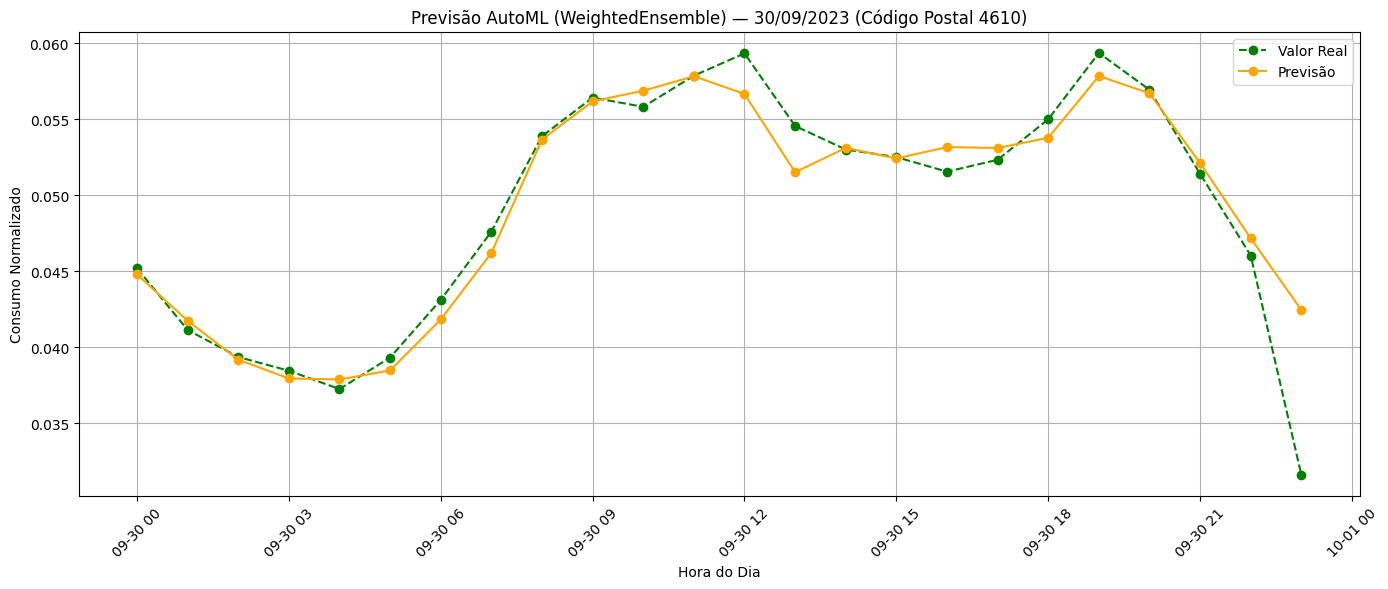

In [7]:
# Extrair os timestamps do índice
timestamps = preds.index.get_level_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão AutoML (WeightedEnsemble) — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/AutoML/grafico.png", dpi=300, bbox_inches='tight')
plt.show()